# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data & Methodology](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

I am a Taiwanese living in Taipei.  
In our country, we don't have a long history so there are few historic buildings in our country.   In contrast, we have lots and lots of street vendors, convenience stores therefore it is convenience.
* I want to figure out if I decide to live in other country, which is suitble for me (that I can quickly get used to it)? 
* I also want to figure out if I want to travel to see different countries, which are sutible for me (that is very different from Taipei)?

## Data & Methodology <a name="data"></a>

The main idea is: If the category distribution of a city is similar to Taipei, then maybe I can quickly get used to it, and vice versa.

For example, in Taipei, we are surrounded by lots of convenience stores, restaurants, and business buildings.  As such, if there's one city in which I live can quickly get to convenience stores, restaurants and business buildings, then I will feel like living in Taipei.  
Otherwise, if there's one city I have to drive at least one hour to get to a convenience store, then I'll go insane.

According to the above, I'll by hand pick 20 big cities in the world, use the data as in module 3 of this course, and find out which one in the 20 cities is most similar to Taipei.  
On the other hands, I can choose one which is most different from Taipei, that will be a best place to travel and to experience different culture and lifestyle.

### First of all, import all things I need...

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

### Pick 20 cities including Taipei by hand

In [2]:
cities = ['Taipei',
          'Paris',
          'New York',
          'Tokyo',
          'Bangkok',
          'Delhi',
          'Shanghai',
          'Cairo',
          'Jakarta',
          'Manila',
          'Seoul',
          'Beijing',
          'Sao Paulo',
          'Mexico City',
          'Guangzhou',
          'Dhaka',
          'Moscow',
          'Los Angeles',
          'Buenos Aires',
          'Kolkata']

In [6]:
CLIENT_IDs = 'abc' # your Foursquare ID
CLIENT_SECRETs = 'def' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
RADIUS = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_IDs)
print('CLIENT_SECRET:' + CLIENT_SECRETs)

Your credentails:
CLIENT_ID: abc
CLIENT_SECRET:def


In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
def dataframe(city):
    
    address = city
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&limit={}&raduis={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, LIMIT, RADIUS)
    results = requests.get(url).json()
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)

    columns = ['name', 'categories', 'location.city', 'location.country']
    dataframe = dataframe[columns]

    # filter the category for each row
    dataframe['categories'] = dataframe.apply(get_category_type, axis=1)

    dataframe.columns = [column.split('.')[-1] for column in dataframe.columns]
    dataframe['city'] = city
    
    return dataframe

### Get each city's venue categories
For example, Taipei has at least one History Museum, at least two city halls,...,etc.

In [23]:
dataframe_all = pd.DataFrame()
for city in cities:
    this_dataframe = dataframe(city)
    dataframe_all = pd.concat([dataframe_all, this_dataframe])
dataframe_filtered = dataframe_all[['city', 'categories']]
dataframe_filtered.head(20)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  del sys.path[0]


,city,categories
0,Taipei,History Museum
1,Taipei,City Hall
2,Taipei,Medical Center
3,Taipei,Post Office
4,Taipei,Business Center
5,Taipei,Plaza
6,Taipei,Coffee Shop
7,Taipei,City Hall
8,Taipei,Bus Station
9,Taipei,Memorial Site


## Analysis <a name="analysis"></a>

1. Clustering these 20 cities using K-means.  
2. Calculating correlations of these 20 cities.

### Clustering

In [24]:
dataframe_onehot = pd.get_dummies(dataframe_filtered[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dataframe_onehot['City'] = dataframe_filtered['city'] 

# move neighborhood column to the first column
fixed_columns = [dataframe_onehot.columns[-1]] + list(dataframe_onehot.columns[:-1])
dataframe_onehot = dataframe_onehot[fixed_columns]

dataframe_onehot.head()

,City,ATM,Airport Service,American Restaurant,Amphitheater,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Ballroom,Bank,Bar,Baseball Field,Baseball Stadium,Bathing Area,Beach,Bed & Breakfast,Beer Garden,Beer Store,Beijing Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Campaign Office,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Castle,Chinese Restaurant,Church,City Hall,Clothing Store,Club House,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Bookstore,College Cafeteria,College Classroom,College History Building,College Lab,College Library,College Residence Hall,College Soccer Field,College Technology Building,College Theater,Comfort Food Restaurant,Comic Shop,Community College,Concert Hall,Conference Room,Convenience Store,Convention,Convention Center,Corporate Cafeteria,Cosmetics Shop,Courthouse,Coworking Space,Credit Union,Cruise,Cultural Center,Cupcake Shop,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Doctor's Office,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Financial or Legal Service,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Government Building,Grocery Store,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indonesian Restaurant,Insurance Office,Internet Cafe,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Kofte Place,Korean Restaurant,Lake,Language School,Laundry Service,Lawyer,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mattress Store,Medical Center,Medical Lab,Mediterranean Restaurant,Meeting Room,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mosque,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Festival,Music Venue,Nail Salon,Nature Preserve,Nightclub,Non-Profit,Noodle House,Notary,Office,Opera House,Optical Shop,Other Event,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pier,Pizza Place,Playground,Plaza,Police Station,Pool Hall,Post Office,Power Plant,Professional & Other Places,Pub,Public Art,Public Bathroom,Racetrack,Ramen Restaurant,Recycling Facility,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Shrine,Skate Park,Ski Area,Ski Shop,Smoke Shop,Snack Place,Soccer Stadium,Social C

#### These vectors stand for features of the 20 cities

In [25]:
dataframe_vec = dataframe_onehot.groupby(['City']).mean().reset_index()
dataframe_vec

,City,ATM,Airport Service,American Restaurant,Amphitheater,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Ballroom,Bank,Bar,Baseball Field,Baseball Stadium,Bathing Area,Beach,Bed & Breakfast,Beer Garden,Beer Store,Beijing Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Campaign Office,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Castle,Chinese Restaurant,Church,City Hall,Clothing Store,Club House,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Bookstore,College Cafeteria,College Classroom,College History Building,College Lab,College Library,College Residence Hall,College Soccer Field,College Technology Building,College Theater,Comfort Food Restaurant,Comic Shop,Community College,Concert Hall,Conference Room,Convenience Store,Convention,Convention Center,Corporate Cafeteria,Cosmetics Shop,Courthouse,Coworking Space,Credit Union,Cruise,Cultural Center,Cupcake Shop,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Doctor's Office,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Financial or Legal Service,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Government Building,Grocery Store,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indonesian Restaurant,Insurance Office,Internet Cafe,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Kofte Place,Korean Restaurant,Lake,Language School,Laundry Service,Lawyer,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mattress Store,Medical Center,Medical Lab,Mediterranean Restaurant,Meeting Room,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mosque,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Festival,Music Venue,Nail Salon,Nature Preserve,Nightclub,Non-Profit,Noodle House,Notary,Office,Opera House,Optical Shop,Other Event,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pier,Pizza Place,Playground,Plaza,Police Station,Pool Hall,Post Office,Power Plant,Professional & Other Places,Pub,Public Art,Public Bathroom,Racetrack,Ramen Restaurant,Recycling Facility,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Shrine,Skate Park,Ski Area,Ski Shop,Smoke Shop,Snack Place,Soccer Stadium,Social C

In [26]:
kclusters = 5

dataframe_drop = dataframe_vec.drop('City', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dataframe_drop)

### Getting the clustering result
We can see that only "Los angeles" is in the same group as Taipei.

In [27]:
dataframe_drop['Group'] = kmeans.labels_
dataframe_drop['City'] = dataframe_vec['City']
dataframe_grouped = dataframe_drop[['City', 'Group']]
dataframe_grouped

,City,Group
0,Bangkok,0
1,Beijing,0
2,Buenos Aires,0
3,Cairo,0
4,Delhi,0
5,Dhaka,0
6,Guangzhou,4
7,Jakarta,0
8,Kolkata,0
9,Los Angeles,1


#### The first result shows that Los Angeles is the most suitable for me to move.

### Correlation

In [28]:
columns = list(dataframe_vec['City'])
dataframe_drop = dataframe_drop.drop('City', 1)
dataframe_drop = dataframe_drop.drop('Group', 1)
dataframe_cor= dataframe_drop.T
dataframe_cor.columns = columns

### Check correlations of these cities...
I find out that "Los Angeles" is most correlated to Taipei, same result as before.  
On the other hand, I also find out that "Sao Paulo" has the least correlation with Taipei. 

In [32]:
cor = dataframe_cor.corr()
cor

,Bangkok,Beijing,Buenos Aires,Cairo,Delhi,Dhaka,Guangzhou,Jakarta,Kolkata,Los Angeles,Manila,Mexico City,Moscow,New York,Paris,Sao Paulo,Seoul,Shanghai,Taipei,Tokyo
Bangkok,1.000000,0.131067,6.637490e-02,0.132660,0.039800,1.839596e-01,0.061218,0.075252,0.105262,0.213774,0.185568,0.017693,0.143925,0.280467,0.130055,0.211716,0.147613,0.017242,0.128674,0.095916
Beijing,0.131067,1.000000,6.919646e-03,0.162703,0.214415,1.363785e-01,0.337410,0.159516,0.083304,0.130184,0.114702,0.263258,0.353412,0.141140,0.118850,0.283903,0.153717,0.184761,0.194387,0.472602
Buenos Aires,0.066375,0.006920,1.000000e+00,0.103322,-0.030602,5.841773e-17,0.048364,0.048625,0.121623,0.006509,-0.014588,0.019570,-0.013422,0.081283,0.188134,0.069934,0.021614,0.009816,0.021705,-0.034680
Cairo,0.132660,0.162703,1.033222e-01,1.000000,0.363100,3.529622e-01,0.166492,0.121208,0.464550,0.120122,0.069093,0.058347,0.115637,0.165944,0.424740,0.155725,0.188330,0.072713,0.127159,0.143501
Delhi,0.039800,0.214415,-3.060206e-02,0.363100,1.000000,2.671121e-01,0.202744,0.146105,0.358347,0.095672,0.008804,-0.007102,0.034610,0.183022,0.149640,0.194480,0.117100,0.063900,0.070219,0.100167
Dhaka,0.183960,0.136379,5.841773e-17,0.352962,0.267112,1.000000e+00,0.236265,0.236233,0.348673,0.235325,0.090564,0.140866,0.002759,0.233891,0.187251,0.055885,0.176475,0.084632,0.155375,0.144176
Guangzhou,0.061218,0.337410,4.836375e-02,0.166492,0.202744,2.362655e-01,1.000000,0.212216,0.216298,0.137264,-0.003456,0.014101,0.004777,0.158563,0.155173,0.130213,0.225860,0.604152,0.244309,0.254887
Jakarta,0.075252,0.159516,4.862523e-02,0.121208,0.146105,2.362326e-01,0.212216,1.000000,0.244248,0.507038,0.113829,0.192995,0.135686,0.369418,0.109723,0.141832,0.226185,-0.021957,0.524928,0.185817
Kolkata,0.105262,0.083304,1.216228e-01,0.464550,0.358347,3.486732e-01,0.216298,0.244248,1.000000,0.108957,0.030522,0.030127,0.021777,0.231624,0.313414,0.195500,0.133152,0.140357,0.042049,0.166295
Los Angeles,0.213774,0.130184,6.508504e-03,0.120122,0.095672,2.353252e-01,0.137264,0.507038,0.108957,1.000000,0.145524,0.194268,0.020218,0.376932,0.150308,0.071740,0.258116,0.005110,0.635494,0.106678


### Visualizing it...

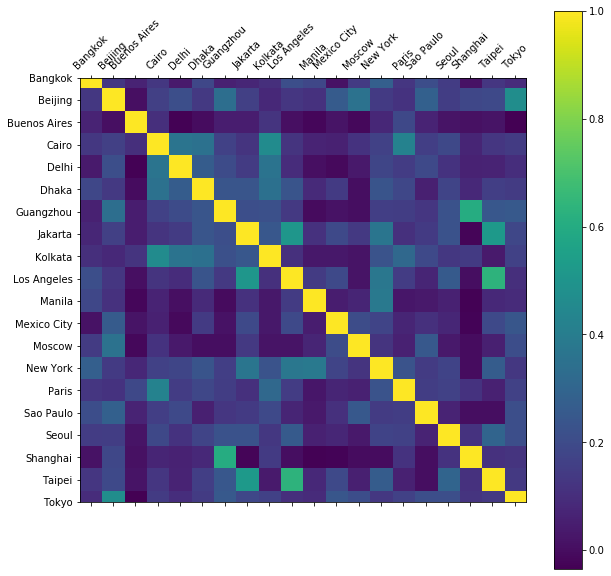

In [33]:
plt.matshow(cor)
plt.gcf().set_size_inches(10, 10)
plt.xticks(np.arange(20), labels = columns, rotation = 45)
plt.yticks(np.arange(20), labels = columns)
plt.colorbar()
plt.show()

## Results and Discussion<a name="results"></a>

According to the above, Los Angeles is highly correlated to Taipei, or say, the most similar to Taipei.  Therefore, we can say that "Los Angeles" is the best place for me to move and to live there.  
Other options:
* Jakarta
* New York
* Seoul


On the other hands, Sao Paulo has the least correlation with Taipei.  Therefore, we can sat that Sao Paulo is the best place for me to go travel and to experience different culture and lifestyle.  
Other options:
* Buenos Aires
* Moscow
* Paris

## Conclusion<a name="conclusion"></a>

I've been to Los Angeles before.  I think thats an excellent city that I can live forever.  However, considering the distance and culture, Seoul may be a good option for me.
By the way, through this assignment, I've written down a list to go travel!